In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load dataset, resample to have balanced classes 

In [44]:
complete_data = pd.read_csv('../resources/data/trolls/data.tsv', sep='\t')

trolling = complete_data[complete_data.label == 1]
not_trolling = complete_data[complete_data.label != 1].sample(len(trolling))

data = pd.concat([trolling, not_trolling])

In [45]:
data

,content,label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook R...,1
2,why did you fuck it up. I could do it all day ...,1
3,Dude they dont finish enclosing the fucking sh...,1
4,WTF are you talking about Men? No men thats no...,1
5,Ill save you the trouble sister. Here comes a ...,1
6,Im dead serious.Real athletes never cheat don'...,1
7,...go absolutely insane.hate to be the bearer ...,1
8,Lmao im watching the same thing ahaha. The ga...,1
9,LOL no he said What do you call a jail cell ...,1


### Train a logistic regression model, using grid search and k-fold cross-validation

In [50]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import HashingVectorizer

import warnings
warnings.filterwarnings('ignore')

def labels_from(df):
    return np.array(df.label == 1)

train_data, heldout_data = train_test_split(data, test_size=0.2)
test_data, target_data = train_test_split(heldout_data, test_size=0.5)

y_train = labels_from(train_data)
y_test = labels_from(test_data)
y_target = labels_from(target_data)


feature_transformation = ColumnTransformer(transformers=[
    ('textual_features', HashingVectorizer(ngram_range=(1,3),n_features=100000), 'content'),
], sparse_threshold=1.0)

param_grid = {
    'learner__loss': ['log'],
    'learner__penalty': ['l2', 'l1', 'elasticnet'],
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

pipeline = Pipeline([
    ('features', feature_transformation), 
    ('learner', SGDClassifier(max_iter=1000))])

search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
model = search.fit(train_data, y_train)

In [51]:
score_on_train_data = accuracy_score(y_train, model.predict(train_data))
score_on_noncorrupted_test_data = accuracy_score(y_test, model.predict(test_data))
score_on_noncorrupted_target_data = accuracy_score(y_target, model.predict(target_data))

print("score on train data: ", score_on_train_data)
print("score on test data: ", score_on_noncorrupted_test_data)
print("score on target data: ", score_on_noncorrupted_target_data)

score on train data:  0.9019974017538162
score on test data:  0.8188311688311688
score on target data:  0.8214285714285714


### Introduce errors (missing values) into unseen test data, record resulting class probability entropies and accuracy score as inputs for the meta regressor

In [74]:
def percentiles_of_probas(predictions):
    probs_class_a = np.transpose(predictions)[0]
    probs_class_b = np.transpose(predictions)[1]
    features_a = np.percentile(probs_class_a, np.arange(0,101,5))
    features_b = np.percentile(probs_class_b, np.arange(0,101,5))  
    return np.concatenate((features_a, features_b), axis=0) 

num_features = 42

In [75]:
import random 

def leetify(df, fraction, column, label_column, label_value):
    # we operate on a copy of the data
    corrupted_df = df.copy(deep=True)
    
    for index, row in corrupted_df.iterrows():
     
        if row[label_column] == label_value and random.random() < fraction:
            leet_content = row[column] \
                .replace('a','4') \
                .replace('e','3') \
                .replace('l','1') \
                .replace('t','7') \
                .replace('s','5') \
                .replace('o','0')
            corrupted_df.at[index, column] = leet_content
    
    return corrupted_df

In [95]:
import random
from tqdm import tqdm

generated_training_data = []

for fraction_of_rows_to_leetify in [0.0, 0.05, 0.25, 0.5, 0.75, 0.99]:    
    for _ in range(0, 100):        

        corrupted_test_data = leetify(test_data, fraction_of_rows_to_leetify, 'content', 'label', 1)

        predictions = model.predict_proba(corrupted_test_data)                     
        features = percentiles_of_probas(predictions)

        score_on_corrupted_test_data = accuracy_score(y_test, model.predict(corrupted_test_data))                

        example = np.concatenate((features, [score_on_corrupted_test_data]), axis=0)                                       

        generated_training_data.append(example)

### Fit a regression model to the generated training data

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X = np.array(generated_training_data)[:,:num_features]
y = np.array(generated_training_data)[:,num_features]

param_grid = {
    'learner__n_estimators': np.arange(5,20,5),
    'learner__criterion': ['mae']
}

meta_regressor_pipeline = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', RandomForestRegressor())
])

meta_regressor = GridSearchCV(meta_regressor_pipeline, param_grid, scoring='neg_mean_absolute_error').fit(X, y)

### Evaluate regression model in predicting effects of errors in the unseen target data

In [97]:
predicted_scores = []
true_scores = []


for fraction_of_rows_to_leetify in [0.0, 0.05, 0.25, 0.5, 0.75, 0.99]:       
    for _ in range(0, 100):        
        corrupted_target_data = leetify(target_data, fraction_of_rows_to_leetify, 'content', 'label', 1)

        predictions = model.predict_proba(corrupted_target_data)
        features = percentiles_of_probas(predictions)                

        score_on_corrupted_target_data = accuracy_score(y_target, model.predict(corrupted_target_data))
        predicted_score_on_corrupted_target_data = meta_regressor.predict([features])

        predicted_scores.append(predicted_score_on_corrupted_target_data)
        true_scores.append(score_on_corrupted_target_data)

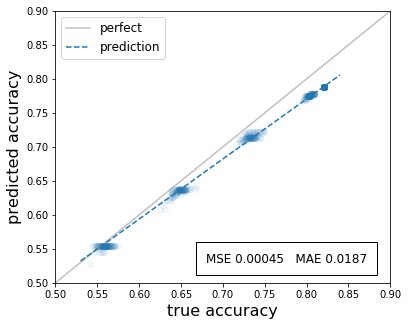

In [119]:
import scipy.stats

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.53, 0.84, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.5, 0.9))
plt.ylim((0.5, 0.9))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(0.68, 0.53, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/trolls-lr.pdf', dpi=300)
plt.show()